# Paolo Fasano - Assignemnt 3 - Midterm 2


Implement from scratch an RBM and apply it to DSET3. The RBM should be implemented fully by you (both CD-1 training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.).

1.     Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website).

2.     Use the trained RBM to encode a selection of test images (e.g. using one per digit type) using the corresponding activation of the hidden neurons.

3.     Reconstruct the original test images from their hidden encoding and confront the reconstructions with the original image (use a suitable quantitative metric to assess the reconstraction quality and also choose few examples to confront visually).

## Step 1: implementing the RBM

In [1]:
import torch 
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class RBM():
    def __init__(self, nVisible, nHidden):
      self.weight = np.random.randn(nVisible, nHidden)
      self.nHidden = nHidden
      self.nVisible = nVisible
      self.biasPhv = np.random.randn(nHidden)
      self.biasPvh = np.random.randn(nVisible)  

    def fit(self, X, batch_size = 32, epochs = 10, learning_rate = 0.5):
      
      for epoch in range(0,epochs):
        error_in_epoch = 0
        batches = list(gen_batches(X.shape[0], batch_size))
        
        for batch in batches:
          batch = X[batch.start:batch.stop]
          batch_size = batch.shape[0]
          
          # Wake
          data = np.ones((batch_size, self.nHidden))
          poshidP = data/(data + np.exp(-np.dot(batch,self.weight) - self.biasPhv)) # Hidden activation probability
          wake = np.dot(batch.T, poshidP)
          
          # Dream
          poshidS = np.ones((batch_size, self.nVisible)) # Stochastic hidden activation
          reconDataP = poshidS / (poshidS + np.exp(-np.dot(poshidP, np.transpose(self.weight))-self.biasPvh)) # Data reconstruction probability
          reconData = np.ones((batch_size, self.nHidden)) # Stochastic reconstructed data
          neghidP = reconData / (reconData + np.exp(-np.dot(reconDataP, self.weight) - self.biasPhv))
          dream = np.dot(np.transpose(reconDataP), neghidP)
          
          # Error
          error = np.sum((batch-reconDataP)**2)/batch_size
          
          # Update CD-1
          self.weight += learning_rate*(wake-dream)/batch_size
          self.biasPhv += learning_rate*(np.sum(poshidP-neghidP, axis=0))/batch_size
          self.biasPvh += learning_rate*(np.sum(batch-reconDataP, axis=0))/batch_size

          error_in_epoch += error
          
        error_in_epoch /= len(batches)
        print(epoch, ": error = ", error_in_epoch)
        
    def inference(self, X):
      data = np.ones((X.shape[0], self.nHidden))
      poshidP = data/(data + np.exp(-np.dot(X,self.weight)-self.biasPhv))
      
      return poshidP


    def reconstruct(self, X):
      ones_poshidP = np.ones((X.shape[0], self.nHidden))
      poshidP = ones_poshidP/(ones_poshidP + np.exp(-np.dot(X,self.weight)-self.biasPhv))
      poshidS = poshidP > np.random.uniform(size=poshidP.shape)
      
      ones_reconDataP = np.ones((X.shape[0], self.nVisible))
      reconDataP = ones_reconDataP / (ones_reconDataP + np.exp(-np.dot(poshidS,np.transpose(self.weight))-self.biasPvh))

      return reconDataP      

The RBM class take as a input the number of hidden and visible neurons.  
- The function fit trains the model, it requires X which are the data, batch_size, epochs, learning_rate;  
- The function inference infers and return the probabilities of the hidden units   
- The function reconstruct recreates the data  

## Step 2: train the RBM

In [3]:
X, Y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=10000)
X_test_copy = X_test #will be used later for comparison and metrics

X_train /= 255
X_train = (X_train > 0.5)

X_test /= 255
X_test = (X_test > 0.5)

print(f"The elements of the dataset are transformed in the binary form: {np.unique(X_train)}")
print(f"Train: {X_train.shape} {Y_train.shape} \t Test: {X_test.shape} {Y_test.shape}")

/home/paolo/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


The elements of the dataset are transformed in the binary form: [False  True]
Train: (60000, 784) (60000,) 	 Test: (10000, 784) (10000,)


In [4]:
rbm = RBM(X_train.shape[1], 50)
rbm.fit(X_train, batch_size = 15, epochs = 15, learning_rate = 0.25)

0 : error =  39.21756702497085
1 : error =  33.525064855788735
2 : error =  32.08656672985406
3 : error =  31.106761628007384
4 : error =  30.006630281799254
5 : error =  29.111533883126278
6 : error =  28.44967166312372
7 : error =  27.959912422851946
8 : error =  27.591920006371566
9 : error =  27.21955384249016
10 : error =  26.997572656275004
11 : error =  26.9120424126184
12 : error =  26.858799911050603
13 : error =  26.83957406961986
14 : error =  26.793526377140772


## Step 3: Encode a selection of test images Reconstruct the original test images

In [7]:
reconstructed = rbm.reconstruct(X_test)

The Euclidean distance between image and reconstruction  1  is:  3.753230357486498
The Euclidean distance between image and reconstruction  2  is:  2.6235671632914657
The Euclidean distance between image and reconstruction  3  is:  4.254180088097861
The Euclidean distance between image and reconstruction  4  is:  3.326644709870413
The Euclidean distance between image and reconstruction  5  is:  4.511708198561285
The Euclidean distance between image and reconstruction  6  is:  2.6378526265206927


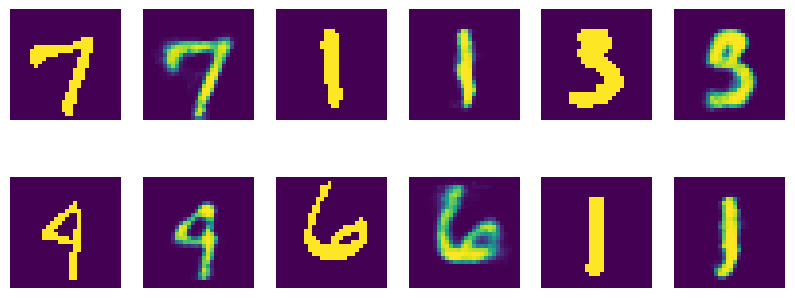

In [22]:
fig = plt.figure(figsize=(10, 4))

rows = 2
columns = 6
j = 1

for i in range(0,6):

    fig.add_subplot(rows, columns, j)
    plt.imshow(X_test[i].reshape((28,28)))
    plt.axis('off')

    fig.add_subplot(rows, columns, j+1)
    plt.imshow(reconstructed[i].reshape((28, 28)))
    plt.axis('off')

    j+=2

for i in range (0,6):
    print("The Euclidean distance between image and reconstruction ", i+1, " is: ", np.linalg.norm(np.asarray(X_test_copy[i])-np.asarray(reconstructed[i])))


As we can see from the results, the RBM is capable of reconstructing the input in a satisfiable way even tho some noise is present in the results. 